## Lab 10: Self-supervised Learning

## What is Self-supervised Learning?

Self-supervised learning is a technique that has machines label data for training. It is supervised learning (i.e., labels are available for training), but the train dataset does not required humans to label it.

## Why Self-supervised Learning?

Good performance of supervised learning often require a huge amount of data and labels, which results in expensive and time-consuming human labeling tasks. There is also a lot of data to use but unsupervised learning is much less efficient compared to supervised learning. 

Self-supervised learning allows us to practice supervised learning while saving time and resources by having machines label data for us.


## Successful Examples of Self-supervised Learning

Self-supervised learning techniques have been successfully used in language modeling. For example, a language model was tasked to predict a masked word given the surrounding words or past sequence. BERT is a successful example.

# Cross-lingual embeddings

In this lab we will explore multilingual word embeddings and build a very rudimentary translation system. By training a translation system, we can start having sentences labeled by machine for future self-supervised tasks.

Adapted from: https://github.com/facebookresearch/MUSE/blob/master/demo.ipynb

Credit to: Phu Mon Htut and Jason Phang.

## Theory
Cross-lingual embedding vectors can be trained in supervised or unsupervised way. We focuses on the supervised way in this lab.  

**Supervised.**  

First, the embeddings are trained for each language separately.   
Then optimization problem of aligning the embeddings is solved using a seed lexicon (small number of aligned pairs of words) by minimizing square loss with cross-domain similarity local scaling (CSLS) criterion.  
More details in [Joulin et al (2018)](https://arxiv.org/pdf/1804.07745.pdf)

More details in [Conneau et al (2018)](https://arxiv.org/pdf/1710.04087.pdf)

## Practice

### Load embeddings
Here we load a subset of 100,000 + 100,000 aligned [fastText embeddings](https://fasttext.cc/docs/en/aligned-vectors.html) for English and Russian languages. 

In [18]:
# !wget 'https://drive.google.com/uc?export=download&id=1-Hrc2uz14kmcsKYle7_penmpR7t0TtZR' -O en_embeddings.npz
# !wget 'https://drive.google.com/uc?export=download&id=1-ZnGxODZypEnz5E0ssXLCEMG-fSfU28W' -O en_word2id.p

# !wget 'https://drive.google.com/uc?export=download&id=1-OE9Tw8M5jWvM-4WRKfladaQzLIgoxiT' -O ru_embeddings.npz
# !wget 'https://drive.google.com/uc?export=download&id=1-Y42yEnIsrQtVdQ7PABrvrn4eYRKmyuG' -O ru_word2id.p

# !wget 'https://drive.google.com/uc?export=download&id=1-TsynEry2jdbIY2P3_c7UjHdbwr345Nf' -O secret_embeddings.npy

In [4]:
import numpy as np
import pickle
import pandas as pd

In [6]:
# load the files
x = np.load('en_embeddings_35.npz', allow_pickle=True)
en_embeddings = [x[k] for k in x][0]

x = np.load('ru_embeddings_35.npz', allow_pickle=True)
ru_embeddings = [x[k] for k in x][0]

with open('en_word2id.p', 'rb') as handle:
    en_word2id = pickle.load(handle)

with open('ru_word2id.p', 'rb') as handle:
    ru_word2id = pickle.load(handle)

# create id2word for both languages
en_id2word = [None] * len(en_word2id)
for word, idx in en_word2id.items():
    en_id2word[idx] = word
ru_id2word = [None] * len(ru_word2id)
for word, idx in ru_word2id.items():
    ru_id2word[idx] = word

### Visualize multilingual embeddings

Let's visualize the embeddings. We take pairs of words that have same meaning, where one is English and the other is Russian. As they exist in 300-dimensional space which is hard to imagine, we need to project them to a 2D space. We will use the first two components of PCA to do this. 

In [7]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, whiten=True)
pca.fit(np.vstack([en_embeddings, ru_embeddings]))
print('Variance explained: %.2f' % pca.explained_variance_ratio_.sum())

Variance explained: 0.15


In [8]:
import matplotlib.pyplot as plt

def plot_similar_word(src_words, src_word2id, src_emb, tgt_words, tgt_word2id, tgt_emb, pca):

    Y = []
    word_labels = []
    for sw in src_words:
        Y.append(src_emb[src_word2id[sw]])
        word_labels.append(sw)
    for tw in tgt_words:
        Y.append(tgt_emb[tgt_word2id[tw]])
        word_labels.append(tw)

    # find PCA coords for 2 dimensions
    Y = pca.transform(Y)
    x_coords = Y[:, 0]
    y_coords = Y[:, 1]

    # display scatter plot
    plt.figure(figsize=(10, 8), dpi=80)
    plt.scatter(x_coords, y_coords, marker='x')

    for k, (label, x, y) in enumerate(zip(word_labels, x_coords, y_coords)):
        color = 'blue' if k < len(src_words) else 'red'  # src words in blue / tgt words in red
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points', fontsize=19,
                     color=color, weight='bold')
        
    for k in range(len(src_words)):
        idx_src = k
        idx_tgt = k + len(src_words)
        plt.plot([x_coords[idx_src], x_coords[idx_tgt]], [y_coords[idx_src], y_coords[idx_tgt]])

    plt.xlim(x_coords.min() - 0.2, x_coords.max() + 0.2)
    plt.ylim(y_coords.min() - 0.2, y_coords.max() + 0.2)
    plt.title('Visualization of the multilingual word embedding space')

    plt.show()

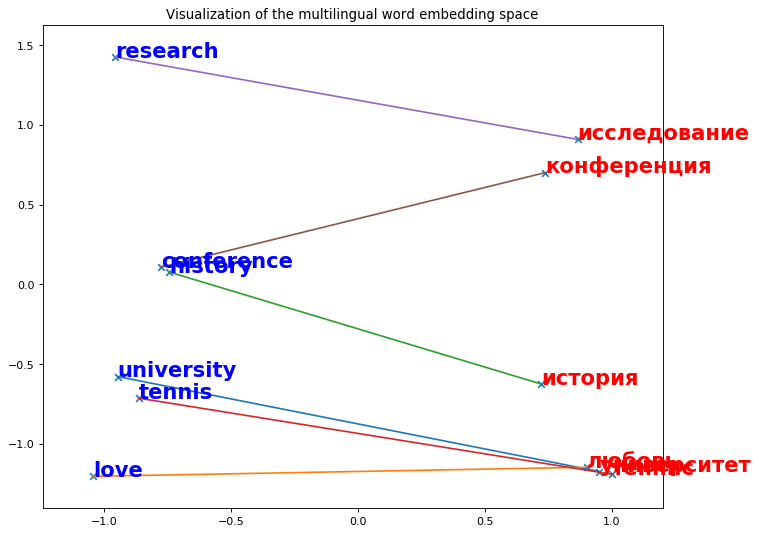

In [9]:
# get 5 random input words
en_words = ['university', 'love', 'history', 'tennis', 'research', 'conference']
ru_words = ['университет', 'любовь', 'история', 'теннис', 'исследование', 'конференция']

# assert words in dictionaries
for en_word in en_words:
    assert en_word in en_word2id, '"%s" not in source dictionary' % en_word
for ru_word in ru_words:
    assert ru_word in ru_word2id, '"%s" not in target dictionary' % ru_word

plot_similar_word(en_words, en_word2id, en_embeddings, ru_words, ru_word2id, ru_embeddings, pca)

### Get nearest neigbors for a given word

Let's write a function that given a word, returns its K nearest neighbors in the vector space.

In [10]:
def get_nn(word, src_emb, src_word2id, tgt_emb, tgt_id2word, K=5):
    # 1. Look up the word embedding
    word_emb = src_emb[src_word2id[word]]

    # 2. Compute the scores for each word
    scores = tgt_emb.dot(word_emb)

    # 3. Find the index of the top K best scoring words
    # 4. Get the corresponding top K words
    k_best = pd.Series(scores, index=tgt_id2word).sort_values(ascending=False)[:K]

    return k_best

def print_k_best_for_word(k_best, word):
    print("Nearest neighbors of \"%s\":" % word)
    for word, score in k_best.items():
        print('%.4f - %s' % (score, word))

    print()

In [11]:
en_words = ["algorithm", "language", "research"]
for word in en_words:
    k_best = get_nn(word, en_embeddings, en_word2id, en_embeddings, en_id2word, K=6)
    print_k_best_for_word(k_best, word)

Nearest neighbors of "algorithm":
0.9999 - algorithm
0.8939 - algorithms
0.7575 - heuristic
0.7427 - recursive
0.7425 - computation
0.7377 - polynomial

Nearest neighbors of "language":
0.9999 - language
0.8152 - languages
0.6772 - linguistic
0.6699 - spoken
0.6548 - bilingual
0.6486 - multilingual

Nearest neighbors of "research":
1.0000 - research
0.7609 - researches
0.7181 - researcher
0.7034 - researchers
0.6741 - biomedical
0.6498 - laboratory



In [12]:
en_words = ["hello", "world"]
for word in en_words:
    k_best = get_nn(word, en_embeddings, en_word2id, en_embeddings, en_id2word, K=3)
    print_k_best_for_word(k_best, word)

Nearest neighbors of "hello":
1.0000 - hello
0.6525 - teahouse
0.6231 - hey

Nearest neighbors of "world":
1.0000 - world
0.6058 - worlds
0.5053 - war



We can also search in Russian and find the closest words in English!

In [13]:
ru_words = ["привет", "мир"]
for word in ru_words:
    k_best = get_nn(word, ru_embeddings, ru_word2id, en_embeddings, en_id2word, K=3)
    print_k_best_for_word(k_best, word)

Nearest neighbors of "привет":
0.3853 - greetings
0.3677 - hello
0.3537 - dear

Nearest neighbors of "мир":
0.3341 - peace
0.3282 - world
0.2986 - worlds



In [14]:
en_words = ["hello", "world"]
for word in en_words:
    k_best = get_nn(word, en_embeddings, en_word2id, ru_embeddings, ru_id2word, K=3)
    print_k_best_for_word(k_best, word)

Nearest neighbors of "hello":
0.3677 - привет
0.3192 - здравствуйте
0.2781 - ох

Nearest neighbors of "world":
0.4323 - мира
0.3403 - мира»
0.3325 - мира —



### A simple word-to-word translation system

We can try to use aligned embeddings to build a very rudimentary translation system.

Here is a list of texts in Russian. We will parse it, convert to lowercase, remove all special symbols, and split to words.   
Then for each word, if it exists in `ru_word2id`, translate it to english (using closest english word), otherwise skip it.

In [15]:
ru_texts = [
"""Игровое действие в американском футболе состоит из серии коротких по продолжительности отдельных схваток, за пределами которых мяч называют «мертвым» или не в игре. Во время схватки могут быть разыграны:
пасовая комбинация,
выносная комбинация,
пант ( удар по мячу ),
попытка взятия зачетной зоны
свободный удар (ввод мяча в игру – начальный удар)
Цель игры – набрать максимальное количество очков, занеся мяч в зачетную зону противника (тачдаун - touchdown) или забив его в ворота с поля (филд-гол – field goals). Побеждает команда, набравшая наибольшее количество очков.""",
"""Я вас любил: любовь ещё, быть может,
В душе моей угасла не совсем;
Но пусть она вас больше не тревожит;
Я не хочу печалить вас ничем.
Я вас любил безмолвно, безнадежно,
То робостью, то ревностью томим;
Я вас любил так искренно, так нежно,
Как дай вам Бог любимой быть другим""",
"""Сегодня мы говорим про слова и стоит обсудить, как делать такое сопоставление вектора слову.
Вернемся к предмету: вот у нас есть слова и есть компьютер, который должен с этими словами как-то работать. Вопрос — как компьютер будет работать со словами? Ведь компьютер не умеет читать, и вообще устроен сильно иначе, чем человек. Самая первая идея, приходящая в голову — просто закодировать слова цифрами по порядку следования в словаре.""",
"""Интернет-мем — информация в той или иной форме (медиаобъект, то есть объект, создаваемый электронными средствами коммуникации, фраза, концепция или занятие), как правило, остроумная и ироническая[2], спонтанно приобретающая популярность, распространяясь в Интернете разнообразными способами (посредством социальных сетей, форумов, блогов, мессенджеров и пр.). Обозначает также явление спонтанного распространения такой информации или фразы. 
Мемами могут считаться как слова, так и изображения. Иначе говоря, это любые высказывания, картинки, видео или звукоряд, которые имеют значение и устойчиво распространяются во Всемирной паутине.""",
]

In [16]:
import re

for ru_text in ru_texts:
    ru_text = re.sub(',(?!\s+\d$)', '', ru_text).lower()
    translation = []

    for word in re.split(r'(\s+)', ru_text):
        # Your code goes here
        if word.isspace():
            candidate = word
        elif word in ru_word2id:
            k_best = get_nn(word, ru_embeddings, ru_word2id, en_embeddings, en_id2word, K=1)
            candidate = list(k_best.keys())[0]
        else:
            candidate = word
        
        translation.append(candidate)

    print("".join(translation))
    print("\n===\n")

игровое action in usa footballing consists from series short by duration individual схваток for outside which ball referred «мертвым» or but in игре. during during fights can be разыграны:
пасовая combination
выносная combination
пант ( blow by мячу (
attempt capture зачетной zones
free blow (ввод goalkeeper in game – initial удар)
aim games – gain maximum number points занеся ball in зачетную zone enemy (тачдаун - touchdown) or scored his in gate with fields (филд-гол – field goals). defeats team набравшая fewest number очков.

===

i you любил: love one be can
in passion my угасла but совсем;
but let she you than but тревожит;
i but want печалить you ничем.
i you loved безмолвно безнадежно
so робостью so ревностью томим;
i you loved that искренно that нежно
as dang you god favorite be direct

===

today we talking like phrases and stands discuss as make that сопоставление vector слову.
вернемся towards предмету: just there we there phrases and there computer which must with between f